## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. Then I will choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [ ]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [ ]:
#Total number of records
n_records = data.shape[0]

#Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income=='>50K'].shape[0]

#Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income=='<=50K'].shape[0]

#Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

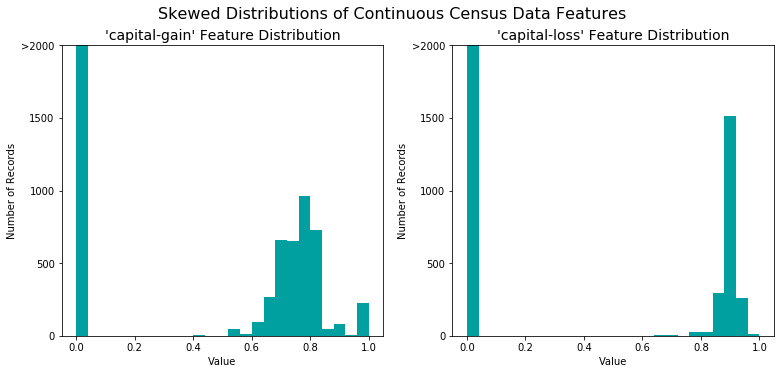

In [50]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

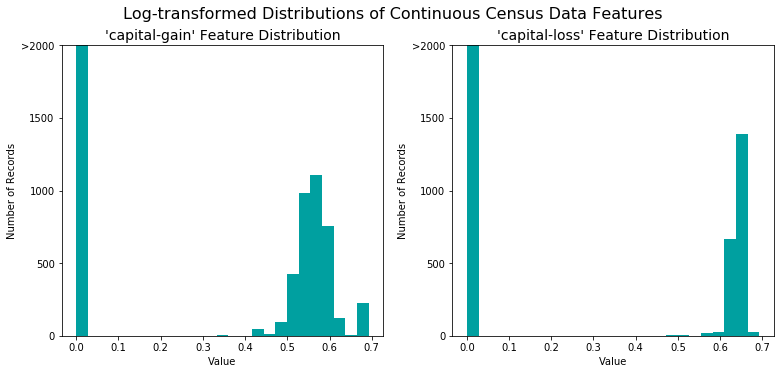

In [48]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [49]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.73768,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

**Practice 1:**
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [21]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

#Encode the 'income_raw' data to numerical values
income = [1 if x=='>50K' else 0 for x in income_raw ]

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

**Practice 2:**  
Using sklearn labelencoder to encode each categorical data

In [11]:
from sklearn.preprocessing import LabelEncoder

categorical_col = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']
coder = LabelEncoder()
features_labelencode = features_log_minmax_transform.copy()
for col in categorical_col:
    features_labelencode[col] = coder.fit_transform(features_log_minmax_transform[col])
features_labelencode.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,5,9,0.8,4,0,1,4,1,0.667492,0.0,0.397959,38


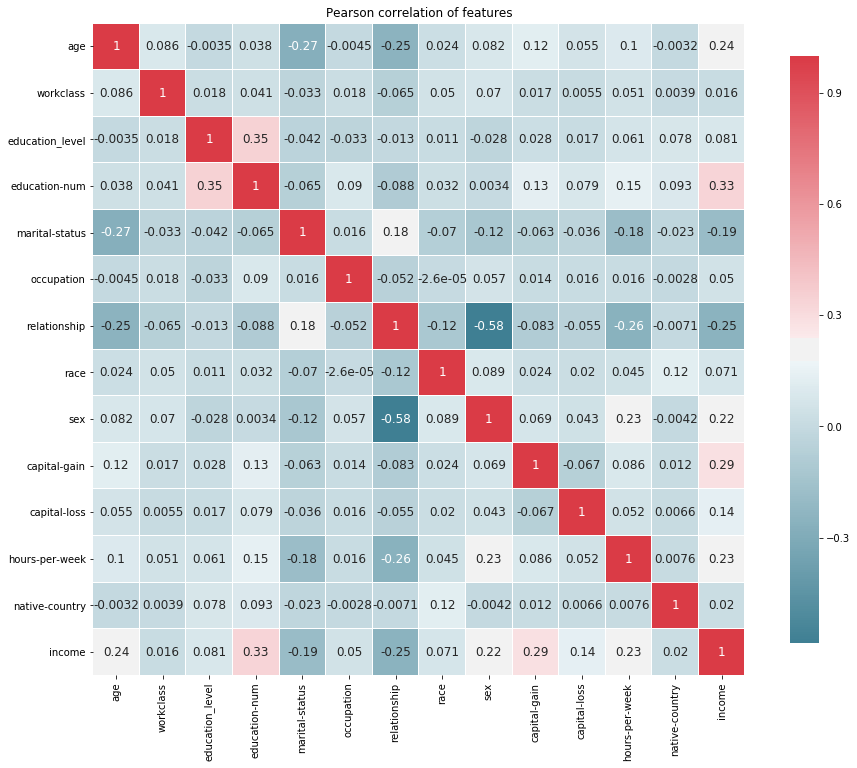

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

data = features_labelencode
data['income'] = income

def corellation_heatmap(df):
    _,ax=plt.subplots(figsize=(16,12))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    ax.set_title('Pearson correlation of features')
    plt.show()
    
corellation_heatmap(data)

From the Pearson correlation we can find that education_num, capital_gain, age,hours_per_week and relationship are more relevant features. We will discuss features' importance later.

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [22]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

In [18]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = len(income) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN)/len(income)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta**2)*(precision*recall)/(beta**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
I will explain and evaluate the following models:
- Decision Trees
- Random Forest
- K-Nearest Neighbors (KNeighbors)

### Question 2 - Model Application  
For each model, I will answer:  
- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

*Decision Tree:*  
Decision tree is an extensively used machine learning model, which is a set of if then questions. Some real-world applications are listed as follows:
1. Hatziargyriou, N. D., Papathanassiou, S. A., and Papadopoulos, M. P. Decision trees for fast security assessment of autonomous power systems with a large penetration from renewables. IEEE Trans. Energy Conversion 10(2):315–325, 1995.  
2. Lee, Y. and Lo, C. Optimizing an air defense evaluation model using inductive learning. Appl.Artif. Intell. 8:645–661, 1994. 
3. Du, R., Elbestawi, M. A., and Wu, S. M. Automated monitoring of manufacturing processes. Part1. Monitoring methods. J. Eng. Ind. 117:121–132, 1995.  

Decision tree's if then method follows the human being's question-answer logic. It is easy to interpret. When used to handle a given case, a decision tree not only provides the solution for that case, but also states the reasons behind its choice. These features are very important in typical application domains in which human experts seek tools to aid in conducting their job while remaining “in the driver’s seat.” Another advantage of using decision trees is the ease and efficiency of their construction compared to that of other classifiers such as neural networks. (Ref: [this](https://booksite.elsevier.com/9780124438804/leondes_expert_vol1_ch3.pdf))
However, decision tree is prone to be overfitting. If it is not carefully pruned, it will not have good generalization performance. 

*Random Forest:*  
Random forest is an ensemble model, which is composed by multiple parallel decision trees. It is a popular ensemble model with pretty good performance. In [this tutorial](https://algobeans.com/2016/08/25/random-forest-tutorial/), random forest is used to predict crime in San Francisco. In [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.318.4422&rep=rep1&type=pdf), random forests is used to provide land classification, which is a good example of the applicability of classifier ensembles to remote sensing. Random forests are generated just like bagged decision trees. Except that, at every decision tree node, the best feature is chosen from a random subset of unused features rather than all the unused features. For the final classification stage each tree gets one vote to determine the winning class to which a given output belongs. Random forest avoids the overfitting problem of decision tree and it does not need prune. However, the model needs to be carefully tuned to obtain best performance. On the other hand, random forest is not as easily interpretable as decision tree. Given our problem is a typical classification problem, random forest could be a ideal candidate.

*K-nearest neighbor:*  
KNN model is a simple and intuitive machine learning model. It use distance between vectors to determine neighbors and major voting to conduct classification. In [this article](https://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/) some real world examples are given. K-nearest neighbor is used in retail to detect patterns in credit card usage. It also used for visual pattern recognition to scan and detect hidden packages in the bottom bin of a shopping cart at check-out. KNN is simple and easy to understand, but it is sensitive to the number of neighbors selected. The number of neighbors should be carefully selected, otherwise it may result in overfitting or underfitting. KNN is suitable for classification problem with limited number of features. When the number of features is big, the efficiency of KNN could become low (if kd tree is used for implementing). Since distance is used to deterrmine neighbors, the numerical values need to be normalized. Since feature number is not big in our model, KNN is a possible candidate for our classification problem.

Suitability for the data:
1. This is a typical binary classification problem.
2. The data set includes both numerical features and categorical features.
3. There are no missing values and all the numerical features were normalized. It is important for the KNN model. But tree based model could handle missing values and does not need normalized data.
4. The number of features (after one-hot encoding) is not big, which could affect the efficiency of the KNN model.  
Because of the above reasons, Decision Tree, Random Forest and KNN are suitable for our dataset.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [19]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
   
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    print(np.sum(predictions_train))
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, I will:
- Import the three supervised learning models discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model, if provided.
  - **Note:** Use the default settings for each model — I will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

67
RandomForestClassifier trained on 361 samples.
67
RandomForestClassifier trained on 3617 samples.
69
RandomForestClassifier trained on 36177 samples.
53
KNeighborsClassifier trained on 361 samples.
55
KNeighborsClassifier trained on 3617 samples.
63
KNeighborsClassifier trained on 36177 samples.
72
DecisionTreeClassifier trained on 361 samples.
71
DecisionTreeClassifier trained on 3617 samples.
65
DecisionTreeClassifier trained on 36177 samples.


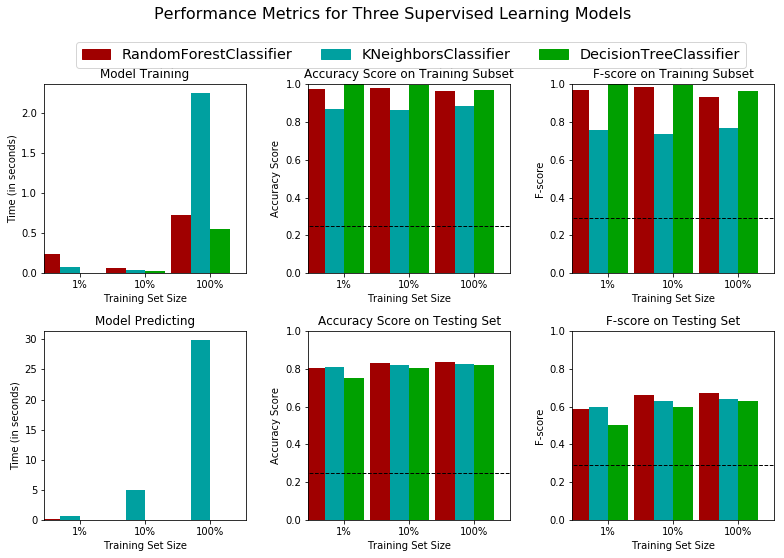

In [23]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# nitialize the three models
random_state = 32
clf_A = RandomForestClassifier(random_state=random_state)
clf_B = KNeighborsClassifier()
clf_C = DecisionTreeClassifier(random_state=random_state)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# amples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

**The confusion matrix of the above three models:**

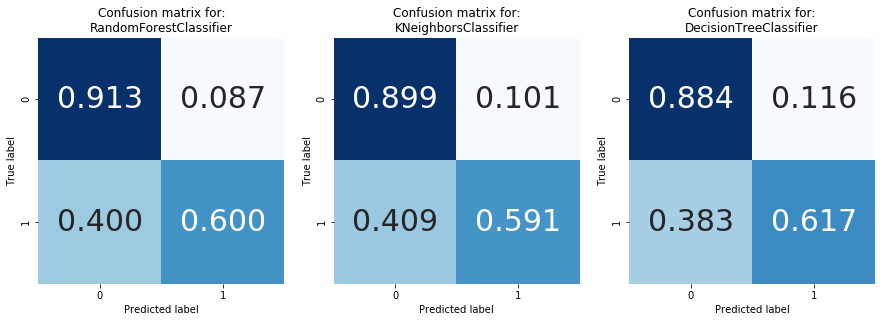

In [45]:
from sklearn.metrics import confusion_matrix

fig,axes = plt.subplots(1,3, figsize=(15,15))
for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, cmap='Blues', square=True, fmt='.3f', cbar=False,ax=axes[i])
    axes[i].set_ylabel('True label')
    axes[i].set_xlabel('Predicted label')
    axes[i].set_title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

----
## Improving Results

By comparing the F score of three models, when 100% training data is used, the random forest model obtains better F score than KNN and decision tree model. While its trainning time is a bit higher than that of dicision tree, it is much less than the trainning time of KNN. It's predicting time is similar as that of decision tree, which is far less than that of KNN. I believe the random forest model is a better one for our classification problem. 

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer: ** 

*Random Forest Classifier:*    
Random forest is an ensemble model, which is composed of multiple parallel decision trees. Before I explain random forest, I would like to illustrate the decision tree first. I would like to use an example to explain this. There is a popular board game called 'who is who'. Indeed, it is a decision tree realization. Two players have some cartoon people's photos. They randomly choose one and start asking the other player questions. For example: is your one boy? The other player may answer yes. Then this player will pick all the boys' photos out. Then they asked questions in turn. Possible questions include: is your one with glasses? is your one with a mustache? etc. The game will over until one player correctly say who the other player's cartoon people is. This 'who is who' board game shows us a way to build up a decision tree. The major difference from the decision tree model is how to ask questions. It uses 'gini' or entropy to determine which question should be asked first, which means we need to determine whether we ask 'boy or girl' first, or 'glasses or not glasses' first. The sequence of questions could determine how many rounds the player can correctly say the answer. Of course, the less the better. 
![who is who](./whoiswho.JPG)
Follow this way, we could build several decision trees at the same time, which composes a random forest (forest always has more than one tree). At every decision tree node, the best feature (the question we will ask) is chosen from a random subset of features rather than all the unused features. For the final classification stage, each tree gets one vote to determine the winning class to which a given output belongs. For example, we have five trees, three of them show the result as a boy, two show it as a girl. Using major voting, the random forest gives boy as the final result.[Reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.133.6529&rep=rep1&type=pdf) 

*Training and predicting:*    
As a classic classification model, the goal of a decision tree classifier is to classify an input to a specific class. While choosing a correct feature, i.e. asking a good question, will determine the how fast a decision tree can make a good answer. The ideal split at each node would be for the left branch to contain class A and the right branch to only contain class B. Then we finished training process. However, it would not be so ideal in reality. We use gini or entropy to measure which feature is better for splitting. The decision tree could grow wildly till each note only has one class, but this is not good. Normally, people try to avoid this by setting the maximum depth of the tree.
 
When making a prediction, the data goes from top to bottom node of the trained model. At each inner node, using previously splitting threshold to make a decision and at the bottom leaf node, the predicted label is used as output. For random Forest, the data goes into multiple trees to make a decision. And at last, each tree's output is a vote for the label. The majority vote determines the final result.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I use the entire training set for this. 
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [24]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#Initialize the classifier
random_state = 32
clf = RandomForestClassifier(random_state=random_state)

#Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[100,500,1000], 
              'criterion': ['entropy'], 
              'max_depth': [5,10,20], 
              'min_samples_split':[2,5,10]
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters,scoring=scorer, cv=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8365
F-score on testing data: 0.6692

Optimized Model
------
Final accuracy score on the testing data: 0.8603
Final F-score on the testing data: 0.7337


In [25]:
grid_fit.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_split': 10,
 'n_estimators': 1000}

### Question 5 - Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**? 

#### Results:

|     Metric     | Naive model |Unoptimized Model | Optimized Model |
| :------------: | :---------: |:---------------: | :-------------: | 
| Accuracy Score |   0.2478    |      0.8365      |   0.8603       |
| F-score        |   0.2917    |      0.6692      |   0.7337       |


**Answer: **
Both accuracy score and F-score of the optimized model are better than that of the unoptimized model. Compared with the naive predictor, which has pretty low accuracy and F score, both unoptimized and optimized mode outperform and the optimized model achieved 86% accuracy and 73.3% F score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:** 
I think age, education_level, marital-status, occupation and hours-per-week are most important features. Among these five features, I think age is the most important one, then followed by occupation, hours-per-week, marital-status and education_level. I believe age is a determine feature because fresh graduate would not get high income. The middle aged person who already worked for several years may has higher probability to earn more. The income is relatted with occupation, some occupations could earn more. The annunal income could related with hours-per-week. If this value is small, it could mean a part time job or causual job. I select marital-status because married persons normally have a family to take care and thus their income need to be maintained at a certain level while single person does not has this concern. Education_level could have certain impact to the income but it is not necessarily true that higher education_level means higher income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

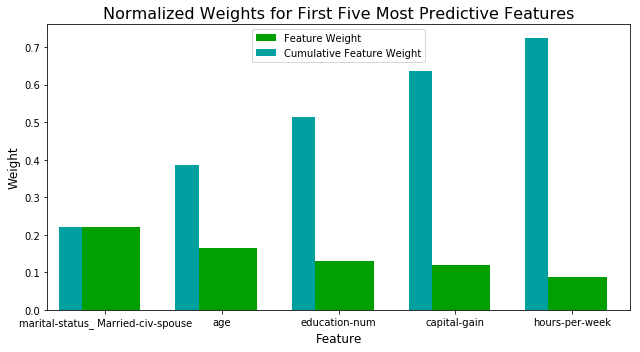

In [46]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.tree import DecisionTreeClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

#Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**  

*How do these five features compare to the five features you discussed in Question 6?*  
There are some overlap between the two results. Marital-status, age and hours-per-week is in the feature list discussed in Question 6. But the rank is different.   

*If you were not close, why do you think these features are more relevant?*  
We use the decision tree classifier with 'gini' number as the measurement for splitting. Gini number is a reflection of impurity after splitting. If this number is bigger, it means the different classes still mixed up. Consider our goal is to separate different classes after splitting, decision tree model selects the feature with smaller gini number for splitting. These five features can provide less impurity value after splitting, and thus they are more relevant features.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [47]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8603
F-score on testing data: 0.7337

Final Model trained on reduced data
------
Accuracy on testing data: 0.8468
F-score on testing data: 0.6963


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
Compared the result obtained from original dataset, both accuracy and F score redused on the data using only five features. Though these five features are most relavate, some detailed information is lost if other data removed from original dataset. However, if trainning time is a critical facotor, using reduced data set is a optimal solusion. By sacrificing a bit performance, speeding up the training process is especially useful for big datasets with large amount of features.